In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from tools.extract import generateNNdata

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


In [2]:
def genXy(data, lb, la, scaler):
    n_features = data.shape[1] - 2
    df = data.reset_index(drop=True)

    X = np.empty((0, lb, n_features))
    y = np.empty((0, la, 2))

    X_time = np.array([], dtype="datetime64")
    y_time = np.array([], dtype="datetime64")

    for i, row in tqdm(df.iterrows()):
        dfx = df.iloc[i : i + lb]
        x_vals = dfx.drop(columns=["timeslot", "date"]).values

        dfy = df.iloc[i + lb : i + lb + la]
        y_vals = dfy[["arrivalsArrivalDelay", "departuresDepartureDelay"]].values

        if dfx.shape[0] < lb or dfy.shape[0] < la:
            continue

        # if dfx.date.nunique() > 1 or dfy.date.nunique() > 1:
        #     continue

        # if dfx.date.unique()[0] != dfy.date.unique()[0]:
        #     continue

        x_vals = scaler.transform(x_vals)
        X = np.vstack((X, x_vals[None]))
        y = np.vstack((y, y_vals[None]))

        X_time = np.append(X_time, dfx.timeslot.iloc[0])
        y_time = np.append(y_time, dfy.timeslot.iloc[0])

    return X, y, X_time, y_time


In [3]:
timeinterval = 30
airport = "EGLL"
lookback, lookahead = 6, 6


In [4]:
dataset = (
    generateNNdata(
        airport,
        timeinterval=timeinterval,
        start=datetime(2018, 1, 1),
        end=datetime(2019, 12, 31),
        catagoricalFlightDuration=False,
        forceRegenerateData=True,
    )
    .drop(columns=["departuresArrivalDelay", "arrivalsDepartureDelay"])
)


Generating NN data for EGLL with a timeslot length of 30 minutes


In [5]:
# randomly split train, test

# np.random.seed(42)
dates = dataset.date.sort_values().unique()
# np.random.shuffle(dates)

idx_split = int(len(dates) * 0.80)

train_dates = dates[:idx_split]
test_dates = dates[idx_split:]

train_data = dataset.query("date in @train_dates").sort_values('timeslot')
test_data = dataset.query("date in @test_dates").sort_values('timeslot')


In [6]:
scaler = StandardScaler()
scaler.fit(dataset.drop(columns=["timeslot", "date"]).values)

StandardScaler()

In [7]:
X_train, y_train, X_train_time, y_train_time = genXy(train_data, lookback, lookahead, scaler)
X_test, y_test, X_test_time, y_test_time = genXy(test_data, lookback, lookahead, scaler)

y_train_arr, y_train_dep = y_train[:, :, 0], y_train[:, :, 1]
y_test_arr, y_test_dep = y_test[:, :, 0], y_test[:, :, 1]


9312it [00:23, 390.31it/s]
2352it [00:04, 523.89it/s]


In [8]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]


In [9]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import MeanSquaredError


inputs = layers.Input((lookback, n_features))
lstm1 = layers.LSTM(200, return_sequences=True)
lstm2 = layers.LSTM(200, return_sequences=False)
dense1 = layers.Dense(200)
dropout1 = layers.Dropout(0.25)
dense2 = layers.Dense(100)
output = layers.Dense(lookahead * 2)
reshape = layers.Reshape((lookahead, 2))

out = lstm1(inputs)
out = lstm2(out)
out = dense1(out)
out = dropout1(out)
out = dense2(out)
outputs = output(out)
outputs = reshape(outputs)

model = models.Model(inputs, outputs)

optimizer = optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_squared_error"),
    weighted_metrics=["acc"],
)

model.summary()


2022-02-15 16:57:15.219247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 16:57:15.228809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 16:57:15.229151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 16:57:15.230023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 12)]           0         
                                                                 
 lstm (LSTM)                 (None, 6, 200)            170400    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 12)                1212  

Epoch 1/100


2022-02-15 16:57:19.047543: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605


291/291 [==============================] - 6s 12ms/step - loss: 54.2581 - acc: 0.8766 - val_loss: 39.8906 - val_acc: 0.9296
Epoch 2/100
291/291 [==============================] - 3s 11ms/step - loss: 37.8054 - acc: 0.8900 - val_loss: 37.3936 - val_acc: 0.8892
Epoch 3/100
291/291 [==============================] - 3s 11ms/step - loss: 34.8106 - acc: 0.8891 - val_loss: 36.2736 - val_acc: 0.8732
Epoch 4/100
291/291 [==============================] - 3s 10ms/step - loss: 34.3777 - acc: 0.8899 - val_loss: 35.2758 - val_acc: 0.8840
Epoch 5/100
291/291 [==============================] - 3s 9ms/step - loss: 32.5777 - acc: 0.8883 - val_loss: 32.8171 - val_acc: 0.8793
Epoch 6/100
291/291 [==============================] - 3s 9ms/step - loss: 32.0988 - acc: 0.8916 - val_loss: 32.0649 - val_acc: 0.8854
Epoch 7/100
291/291 [==============================] - 3s 9ms/step - loss: 31.5612 - acc: 0.8939 - val_loss: 32.2404 - val_acc: 0.8850
Epoch 8/100
291/291 [==============================] - 3s 9ms/s

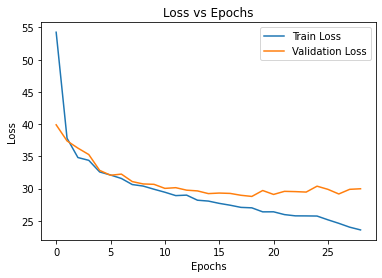

In [10]:

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Fit data
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    # verbose=0,
    shuffle=False,
    callbacks=[es],
)

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [11]:
y_test_hat = model.predict(X_test)


In [12]:
results = pd.concat(
    [
        pd.DataFrame().assign(time=y_test_time),
        pd.DataFrame(
            y_test[:, :, 0].round().astype(int),
            columns=[f"arr_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test[:, :, 1].round().astype(int),
            columns=[f"dep_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 0].round().astype(int),
            columns=[f"arr_est_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 1].round().astype(int),
            columns=[f"dep_est_{n}m" for n in range(30, 181, 30)],
        ),
    ],
    axis=1,
)

# results


In [13]:
res = dict()
for i in range(1, 7):
    res[i] = {
        "arr_mae": mean_absolute_error(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "arr_rmse": mean_squared_error(
            results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"], squared=False
        ),
        "arr_r2": r2_score(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "dep_mae": mean_absolute_error(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
        "dep_rmse": mean_squared_error(
            results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"], squared=False
        ),
        "dep_r2": r2_score(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
    }

pd.DataFrame.from_dict(res, orient="index")

,arr_mae,arr_rmse,arr_r2,dep_mae,dep_rmse,dep_r2
1,4.344724,5.995050,0.718723,2.118753,3.101033,0.510740
2,4.568560,6.327898,0.686767,2.154208,3.275803,0.454038
3,4.817172,6.772088,0.641717,2.214438,3.469277,0.393743
4,4.976933,7.070313,0.609487,2.290901,3.599148,0.347504
5,5.218283,7.498654,0.560673,2.343870,3.635402,0.334292
6,5.438701,7.808855,0.523594,2.393422,3.699002,0.310796


In [14]:

results.to_csv("data/airport_delay_lstm_results.csv", index=False)


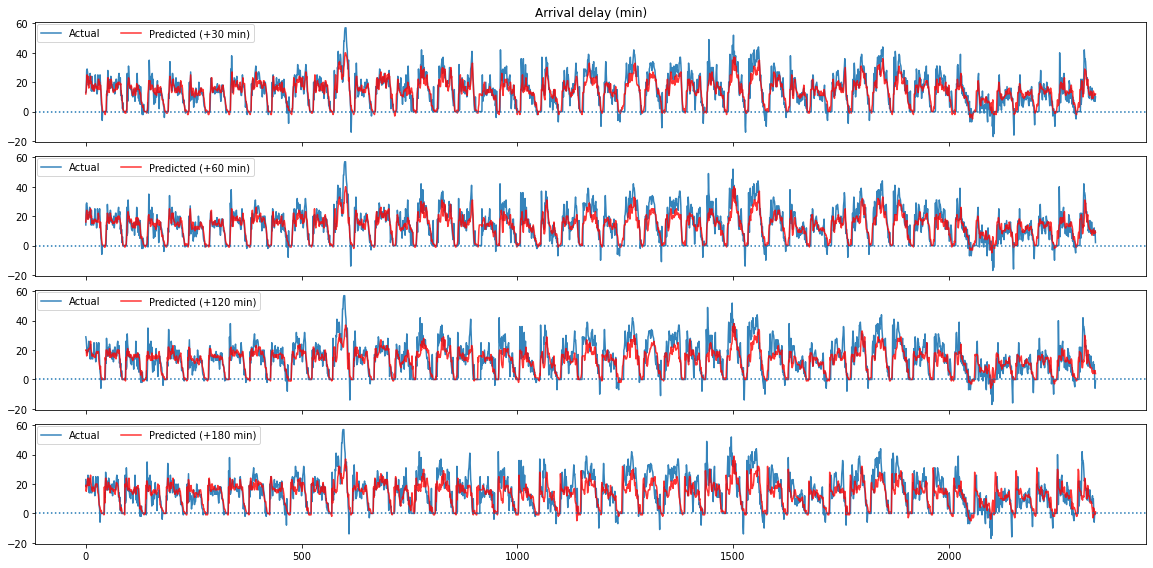

In [18]:
df = results

fig, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.arr_30m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Arrival delay (min)")


ax = axes[1]
ax.plot(df.arr_60m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.arr_120m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.arr_180m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)


plt.tight_layout()

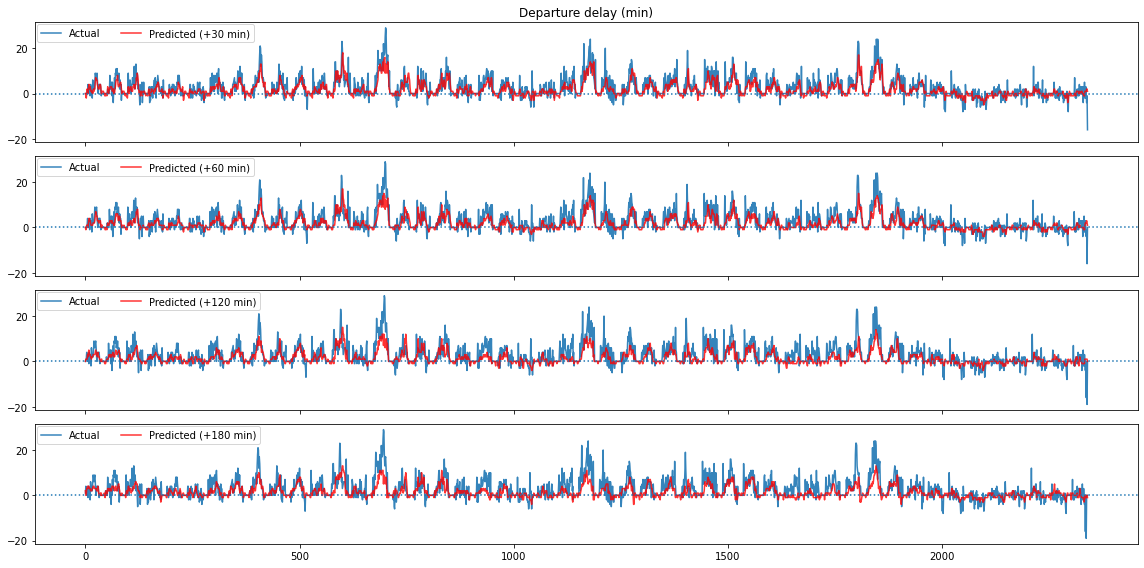

In [19]:
fig, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.dep_30m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Departure delay (min)")


ax = axes[1]
ax.plot(df.dep_60m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.dep_120m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.dep_180m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

plt.tight_layout()
